# Example 2d GP in Mass-Accretion space

A worked 2d example with GPy

## Imports etc

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import GPy

In [3]:
%run ~/.jupyter/config.ipy

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Data

This is some data that I think Enia gave me showing the quality of fit for some mass and gamma bins to some data (I think delta sigma profiles). She wanted to run an MCMC on this data to find the posterior distribution of mass gamma. Rather than run a straight MCMC, this is the training set for a GP that can then be used for the MCMC.

In [10]:
data = np.load("adaptive_bins_all_gamma_m_13_15_chi2_processed_hr_1000.npy")

mean_mass = np.mean(data[:,:2], axis=1)
mean_gamma = np.mean(data[:,2:4], axis=1)
chi2 = data[:,4]

Naively, it seems like M~13.7 with no strong constraints on gamma


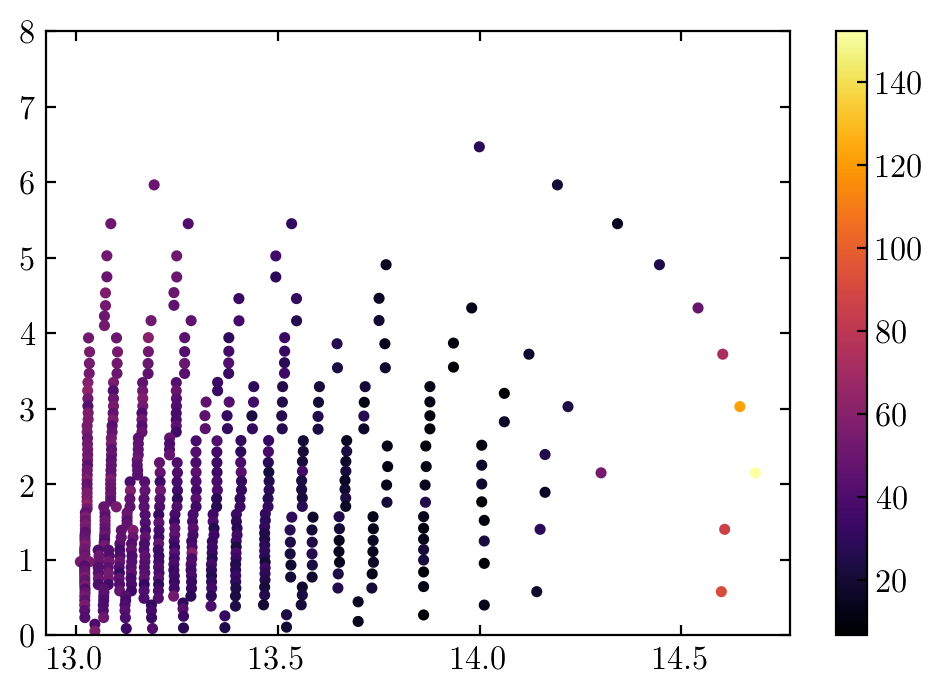

In [37]:
fig, ax = plt.subplots()
img = ax.scatter(mean_mass, mean_gamma, c=chi2, cmap="inferno")
fig.colorbar(img)
ax.set(ylim=(0, 8))
print("Naively, it seems like M~13.7 with no strong constraints on gamma")

# GP

In [22]:
# Construct the data and target vectors - each row is a single data point
x = np.vstack((mean_mass, mean_gamma)).T
y = chi2.reshape(-1, 1)

# Specify a 2d RBF kernel with some initial values. These aren't that important because we optimize them below
# Important that we specify automatic relevance determination (ARD). This allows different length scales for different axes
k = GPy.kern.RBF(2, variance=0.1, lengthscale=[5, 1], ARD=True)
m = GPy.models.GPRegression(x, y, k)

In [23]:
m.optimize(messages=True)

# Check results

In [29]:
# Construct a test grid so that we can check if this is any good
xx, yy = np.meshgrid(np.linspace(13, 14.5), np.linspace(0, 6))
test_x = np.concatenate((xx.reshape(-1, 1), yy.reshape(-1, 1)), axis=1)

In [30]:
# Use the GP to predict the y values at the x in our test grid
test_y = m.predict(test_x)

As expected M (13.7 - 14) but no constraints on gamma


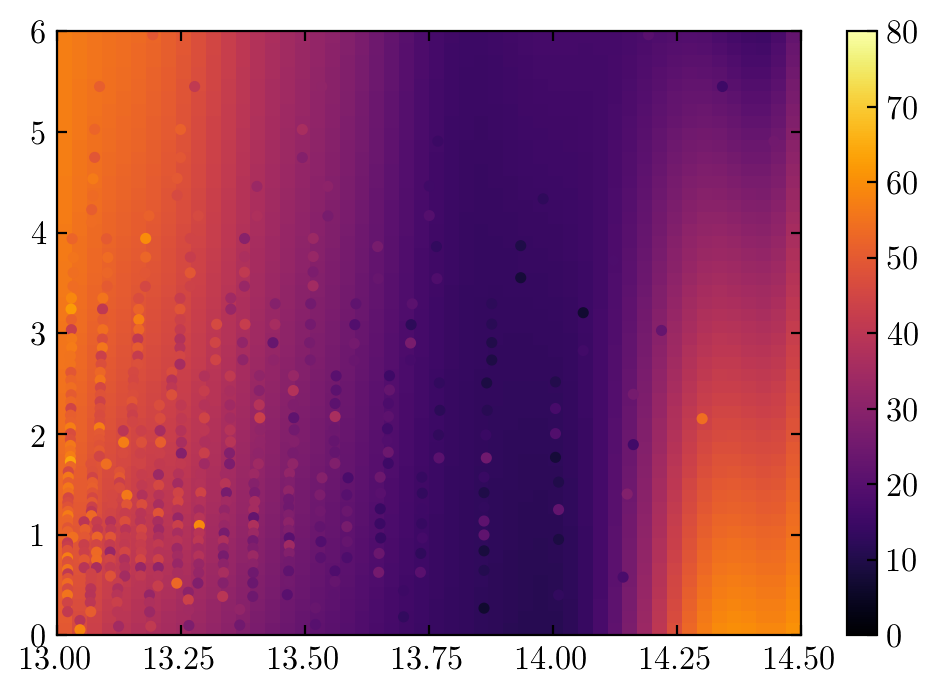

In [38]:
# Plot the training points on the test grid to see if it is close
c_max = 80

fig, ax = plt.subplots()
img = ax.imshow(
    test_y[0].reshape(xx.shape),
    origin="lower",
    extent=[xx[0][0], xx[0][-1], yy[0][0], yy[-1][0]],
    aspect="auto",
    cmap="inferno",
)
img.set_clim(0, c_max)

img2 = ax.scatter(mean_mass, mean_gamma, c=chi2, cmap="inferno")
img2.set_clim(0, c_max)

ax.set(
    xlim=(xx[0][0], xx[0][-1]),
    ylim=(yy[0][0], yy[-1][0]),
)
fig.colorbar(img)

print("As expected M (13.7 - 14) but no constraints on gamma")

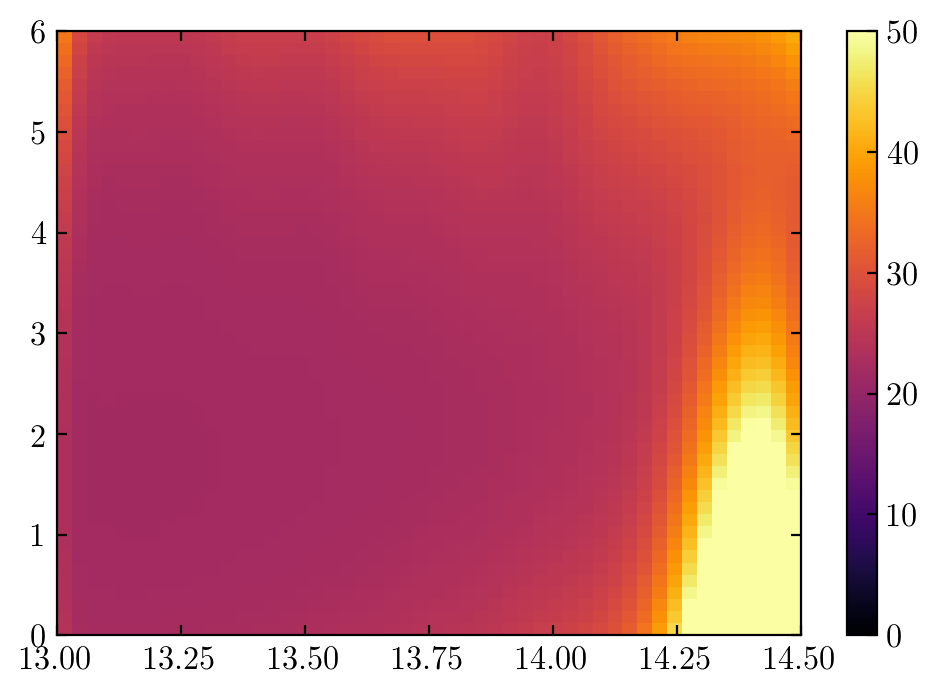

In [39]:
# Plot the uncertainties. These are quite high
# It looks like there is a decent uncertainty on the data? Nearby points often have quite different chi2?
fig, ax = plt.subplots()
img = ax.imshow(
    test_y[1].reshape(xx.shape),
    origin="lower",
    extent=[xx[0][0], xx[0][-1], yy[0][0], yy[-1][0]],
    aspect="auto",
    cmap="inferno",
)
fig.colorbar(img)
img.set_clim(0, 50)